Vamos a intentar usar el código de la notebook `Priorizacion_con_red_chiquita` para la red completa de la notebook `05` o alguna subred interesante de ella.

In [1]:
%run imports.py
%run utils.py
%run leer_red.py

/home/juan/miniconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
%%time

red = leer_subred_nx() # Tarda ~20s
red_df = leer_subred_df()

print(f"{red.number_of_nodes():,} nodos en la red")
print(f"{red.number_of_edges():,} enlaces en la red")

37,823 nodos en la red
226,723 enlaces en la red
CPU times: user 19.4 s, sys: 373 ms, total: 19.8 s
Wall time: 19.7 s


In [3]:
adj_matrix = nx.adj_matrix(red).toarray()
adj_matrix.shape

'11.44 GB'

In [4]:
red_df.fenotipo.value_counts().head(20)

General cognitive ability                                                           1255
Schizophrenia                                                                       1086
Type 2 diabetes                                                                      938
Breast cancer                                                                        839
Intelligence (MTAG)                                                                  645
Multiple sclerosis                                                                   581
Coronary artery disease                                                              533
Systemic lupus erythematosus                                                         445
Crohn's disease                                                                      316
Bipolar disorder                                                                     302
Autism spectrum disorder or schizophrenia                                            301
Colorectal cancer    

In [11]:
import sys
from humanfriendly import format_size

format_size(sys.getsizeof(adj_matrix))

'11.44 GB'

In [5]:
fenos_entrada = [
    "General cognitive ability"
]

#
#
# OJO: Esto tiene un pico fuerte de uso de RAM! ~12 Gb
#
#

TENGO_MUCHA_RAM = False

if TENGO_MUCHA_RAM:
    
    labels = [0 if nodo in fenos_entrada else -1
              for nodo in red.nodes()]

    # En este paso la matriz original ocupa la RAM:
    adj_matrix_t = torch.FloatTensor(adj_matrix)

    # Al instanciarse LabelSpreading, normaliza la matriz y
    # ahora hay dos matrices en memoria:
    label_spreading = LabelSpreading(adj_matrix_t)

    labels_t = torch.LongTensor(labels)
    label_spreading.fit(labels_t, alpha=.8)

    # Borramos las referencias a las dos matrices, este paso libera la RAM:
    del adj_matrix_t
    label_spreading.norm_adj_matrix = None

Iteración:   4%|▍         | 38/1000 [00:03<01:32, 10.44it/s]


The method stopped after 39 iterations, variation=0.0009.


In [13]:
spreading = pd.DataFrame({
    "nodo": red.nodes(),
    "prediccion": label_spreading.flat_predictions,
})

feno_a_categoria = red_df.set_index("fenotipo").categoria_fenotipo.to_dict()

spreading = spreading.sort_values(by="prediccion", ascending=False)
spreading["es_fenotipo"] = spreading.nodo.isin(red_df.fenotipo)
spreading["categoria_fenotipo"] = spreading.nodo.map(feno_a_categoria)
spreading["prediccion_log10"] = spreading.prediccion.map(np.log10)

spreading.query("es_fenotipo").head(10)

/home/juan/miniconda3/lib/python3.7/site-packages/pandas/core/base.py:1145: RuntimeWarning: divide by zero encountered in log10
  new_values = map_f(values, mapper)


,nodo,prediccion,es_fenotipo,categoria_fenotipo,prediccion_log10
27612,General cognitive ability,0.376402,True,Neuro/Cogni/Emo,-0.424348
28193,Intelligence (MTAG),0.019433,True,Neuro/Cogni/Emo,-1.711455
36004,"Cognitive ability, years of educational attainment or schizophrenia (pleiotropy)",0.002958,True,Neurological disorder,-2.529052
35441,Autism and educational attainment (MTAG),0.002454,True,Neurological disorder,-2.610211
37213,Schizophrenia,0.001876,True,Neurological disorder,-2.726694
27600,Extremely high intelligence,0.001776,True,Neuro/Cogni/Emo,-2.750489
27503,Adventurousness,0.001438,True,Neuro/Cogni/Emo,-2.842105
35444,Autism and major depressive disorder (MTAG),0.001367,True,Neurological disorder,-2.864102
32338,Gastroesophageal reflux disease,0.001220,True,Digestive system disorder,-2.913713
36132,Depressed affect,0.001196,True,Neurological disorder,-2.922256


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[]

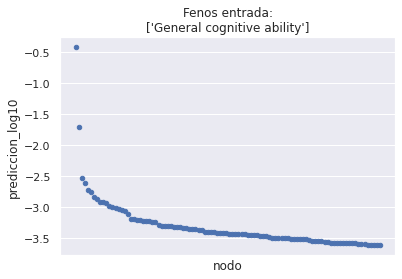

In [14]:
ax = spreading.query("es_fenotipo").head(100).plot.scatter(x="nodo", y="prediccion_log10")
ax.set_title(f"Fenos entrada:\n{fenos_entrada}")
ax.set_xticks([])